# Analyzing inconsistencies in the JEFF-4.0T0 plutonium-237 evaluation

After processing the Pu237 evaluation from JEFF-4.0T0 into ACE we format, we observed the following error running Serpent.

```bash
Fatal error in function ProcessEDistributions:

Unable to process E interpolation (94237.09c mt 18)

Simulation aborted.
```

This error appears to be caused by some inconsistencies in the nubar data.

In the rest of this notebook we use sandy to investigate the nuclear data file.

Let's import sandy and some useful python packages.

In [1]:
%%capture --no-stdout
import sandy

In [2]:
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

%matplotlib inline

The JEFF-4.0T0 evaluation for Pu-237 is taken from the OECD/NEA website.

In [3]:
url = "https://www.oecd-nea.org/dbdata/nds/JEFF4T0/endf6/files/94-pu-237g.endf2c"
with urllib.request.urlopen(url) as f:
    text = f.read().decode('utf-8')

Read the file using sandy.

In [4]:
%%capture
tape = sandy.Endf6.from_text(text)

This is what was stored in section MF=1, MT=455 (delayed nubar).

In [5]:
del_nubar = tape.read_section(9431, 1, 455)
del_nubar

{'MAT': 9431,
 'MF': 1,
 'MT': 455,
 'ZA': 94237.0,
 'AWR': 235.0121,
 'LDG': 0,
 'LNU': 2,
 'LAMBDA': [1.0],
 'NBT': [5],
 'INT': [2],
 'E': array([1.e-05, 4.e+06, 7.e+06, 2.e+07, 2.e+08]),
 'NU': array([0.002 , 0.002 , 0.0014, 0.0014, 0.0014])}

Let's plot nubar as a function of energy.

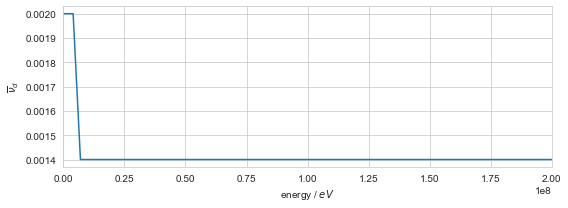

In [6]:
fig, ax = plt.subplots(figsize=(8, 3))
pd.Series(del_nubar["NU"], index=del_nubar["E"]).plot(ax=ax)
ax.set_xlim([0, del_nubar["E"][-1]])
ax.set_xlabel("energy / $eV$")
ax.set_ylabel("$\\overline{\\nu}_d$")
plt.tight_layout();

Only one decay constant is given, which corresponds to only one family of precursors.  

In [7]:
del_nubar['LAMBDA']

[1.0]

However, delayed neutron spectra are given for six precursor families.

In [8]:
mf5 = tape.read_section(9431, 5, 455)
len(mf5["PDISTR"])

6

Let's plot each spectrum as a function of energy!

In [9]:
dfs = []
for k, v in mf5["PDISTR"].items():
    df = pd.DataFrame(dict(energy=v["E_G"], spectrum=v["G"], group=k + 1))
    dfs.append(df)
data = pd.concat(dfs)
data["group"] = data["group"].astype("category")

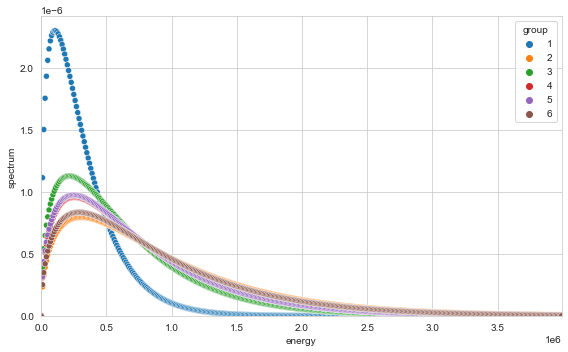

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(data=data, x="energy", y="spectrum", hue="group", ax=ax)

ax.set_xlim([0, data.energy.max()])
ax.set_ylim([0, None])

plt.tight_layout();